In [1]:
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import tensorflow as tf


from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')

import datetime


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()
#tf.debugging.disable_traceback_filtering()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [29]:
input_net = Input((32, 32, 3))

#y = layers.Conv2D(filters=32, kernel_size = 3, activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
y = layers.Conv2D(kernel_size = 3, filters=8, activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
y = layers.Conv2D(kernel_size = 3, filters=16, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.Conv2D(kernel_size = 3, filters=16, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
y = layers.Conv2D(kernel_size = 3, filters=32, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.Conv2D(kernel_size = 3, filters=32, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.Conv2D(kernel_size = 3, filters=32, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)

y = layers.Dropout(0.5)(y)

y = layers.Flatten()(y)
y = layers.Dense(256, activation=ReLU())(y)
y = layers.Dropout(0.5)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                       

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


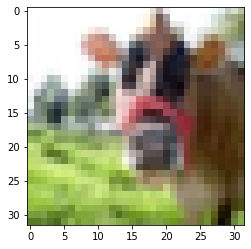

In [27]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [30]:
model = Model(inputs = input_net, outputs = output_net)


optimizer = tf.keras.optimizers.RMSprop()


model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)



batch_size = 256
epochs = 30
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
196/196 [==============================] - 5s 18ms/step - loss: 4.2459 - accuracy: 0.0495 - top-5-accuracy: 0.1829 - val_loss: 3.8989 - val_accuracy: 0.0991 - val_top-5-accuracy: 0.2985
Epoch 2/30
196/196 [==============================] - 3s 15ms/step - loss: 3.8491 - accuracy: 0.1075 - top-5-accuracy: 0.3145 - val_loss: 3.6554 - val_accuracy: 0.1413 - val_top-5-accuracy: 0.3763
Epoch 3/30
196/196 [==============================] - 3s 15ms/step - loss: 3.6092 - accuracy: 0.1488 - top-5-accuracy: 0.3907 - val_loss: 3.3598 - val_accuracy: 0.2064 - val_top-5-accuracy: 0.4756
Epoch 4/30
196/196 [==============================] - 3s 15ms/step - loss: 3.4403 - accuracy: 0.1798 - top-5-accuracy: 0.4403 - val_loss: 3.2323 - val_accuracy: 0.2167 - val_top-5-accuracy: 0.4983
Epoch 5/30
196/196 [==============================] - 3s 15ms/step - loss: 3.3203 - accuracy: 0.1999 - top-5-accuracy: 0.4735 - val_loss: 3.3015 - val_accuracy: 0.2071 - val_top-5-accuracy: 0.4835
Epoch 6/30
196/

In [13]:
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v

In [31]:
def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    if 'conv' not in layer.name:
        raise ValueError('Layer must be a conv. layer')
    # get filter weights
    filters, biases = layer.get_weights()
    print("biases shape : ", biases.shape)
    print("filters shape : ", filters.shape)

    return (filters)
    #print(layer.name, filters.shape)

# I use sobel to determine the dominant orientation of the filter
def getSobelAngle(f):

    s_h = sobel_h(f)
    s_v = sobel_v(f)

    return np.abs((np.degrees(np.arctan2(s_h,s_v))% 360)-180)
def getSymAntiSym(filter):

    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filter)

    mat_flip_y = np.flipud(filter)

    mat_flip_xy =  np.fliplr( np.flipud(filter))

    sum = filter + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)
    
    return  (sum + mat_sum_rot_90) / 8, filter - ((sum + mat_sum_rot_90) / 8)

In [1]:
LAYER = 3
filters = get_filter(LAYER)

FILTER = [15]#list(range(filters.shape[-1]))
CHANNEL = list(range(filters.shape[-2]))


thetas = []
for i, channel in enumerate(CHANNEL):
    for filter in FILTER:
        
        f = filters[:,:,:, filter]
        f = f[:,:, channel]  
        s, a = getSymAntiSym(f)
        sym_mag = np.linalg.norm(s) 
        anti_mag = np.linalg.norm(a) 
        if anti_mag > sym_mag*1.2:

            theta = getSobelAngle(f)
            theta = theta[theta.shape[0]//2, theta.shape[1]//2]
            thetas.append(theta)

plt.hist(thetas, bins=36)
plt.xticks(np.arange(0, 181, step=30), size='small', rotation=0)    

plt.show()
print(len(thetas))
print(thetas)

NameError: name 'get_filter' is not defined